In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene detection

What fraction of polyA genes from the annotation do we detect with >= 1 TPM in any library?

In [5]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, inds = get_tpm_table(df,
                   how='gene',
                   min_tpm=1,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 31968


In [6]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')

In [7]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.index)

print('Detected {} / {} annotated polyA genes'.format(n_det_polya, n_polya))

Detected 31968 / 49472 annotated polyA genes


How many polyA genes do we detect >= 100 TPM in any 1 sample? 

In [15]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, inds = get_tpm_table(df,
                   groupby='sample',
                   how='gene',
                   min_tpm=100,
                   gene_subset='polya')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 100 tpm: 9622
Applying gene type and novelty subset
Averaging over biosample
Found 31 total samples
Number of genes reported: 9025


In [16]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
gene_df = gene_df[['gid', 'gname', 'biotype']]
df = df.merge(gene_df, how='left', left_index=True, right_on='gid')

In [17]:
df = df[['gid', 'biotype']].groupby('biotype').count()
df.rename({'gid':'obs_counts'}, axis=1, inplace=True)

In [18]:
gene_df = gene_df[['gid', 'biotype']].groupby('biotype').count()
gene_df.rename({'gid':'annot_counts'}, axis=1, inplace=True)

In [19]:
df = df.merge(gene_df, how='left', left_index=True, right_index=True)

,obs_counts,annot_counts
biotype,,
antisense,63,5587
bidirectional_promoter_lncRNA,2,73
lincRNA,73,7635
polymorphic_pseudogene,3,41
processed_pseudogene,46,10198


In [21]:
df['perc'] = (df.obs_counts/df.annot_counts)*100
df = df.sort_values(by='perc', ascending=False)
df

,obs_counts,annot_counts,perc
biotype,,,
protein_coding,8773,19969,43.933096
polymorphic_pseudogene,3,41,7.317073
processed_transcript,28,601,4.658902
transcribed_unitary_pseudogene,5,124,4.032258
bidirectional_promoter_lncRNA,2,73,2.739726
transcribed_unprocessed_pseudogene,14,885,1.581921
transcribed_processed_pseudogene,6,481,1.247401
antisense,63,5587,1.127618
sense_overlapping,2,180,1.111111


In [8]:
df.to_csv('polya_genes_100tpm.tsv', sep='\t', index=False)

In [17]:
df = pd.read_csv('polya_genes_100tpm.tsv', sep='\t')

In [19]:
df.loc[df.gname == 'MAP4K4']

,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,gid,gname
686,26.187769,8.586867,20.220004,19.679618,15.021649,74.021218,17.740471,54.516252,36.307251,24.89963,...,20.428229,69.467907,355.849846,9.8552,143.535158,42.008378,56.481392,31.355268,ENSG00000071054.16,MAP4K4


## How many genes of each biotype category are there in the annotation and detected by us?

In [10]:
# get detected genes w/o subsetting on polyA genes
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, _ = get_tpm_table(df,
                   how='gene',
                   min_tpm=1)
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 33706


In [ ]:
#### df = df.merge(gene_df, how='left', left_index=True, right_on='gid')
temp = df[['gid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

## How many genes in other biotype categories do we detect and what proportion of the annotation does this represent?

In [12]:
temp = df[['gid', 'biotype', 'biotype_category']].groupby(['biotype', 'biotype_category']).count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_counts, on='biotype', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)

In [13]:
temp

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
20,non_coding,lncRNA,2.0,2,1.000000
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
1,IG_C_gene,other,14.0,14,1.000000
17,macro_lncRNA,lncRNA,1.0,1,1.000000
9,TR_C_gene,other,6.0,6,1.000000
24,protein_coding,protein_coding,18590.0,19969,0.930943
15,bidirectional_promoter_lncRNA,lncRNA,66.0,73,0.904110
23,processed_transcript,lncRNA,521.0,601,0.866889
36,transcribed_unitary_pseudogene,pseudogene,96.0,124,0.774194


Protein coding genes

In [14]:
temp

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
20,non_coding,lncRNA,2.0,2,1.000000
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
1,IG_C_gene,other,14.0,14,1.000000
17,macro_lncRNA,lncRNA,1.0,1,1.000000
9,TR_C_gene,other,6.0,6,1.000000
24,protein_coding,protein_coding,18590.0,19969,0.930943
15,bidirectional_promoter_lncRNA,lncRNA,66.0,73,0.904110
23,processed_transcript,lncRNA,521.0,601,0.866889
36,transcribed_unitary_pseudogene,pseudogene,96.0,124,0.774194


"Other" genes

In [15]:
temp.loc[temp.biotype_category == 'other']

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
29,scRNA,other,1.0,1,1.000000
6,Mt_rRNA,other,2.0,2,1.000000
1,IG_C_gene,other,14.0,14,1.000000
9,TR_C_gene,other,6.0,6,1.000000
8,TEC,other,448.0,1060,0.422642
7,Mt_tRNA,other,9.0,22,0.409091
28,ribozyme,other,3.0,8,0.375000
26,rRNA,other,16.0,58,0.275862
11,TR_J_pseudogene,other,1.0,4,0.250000
12,TR_V_gene,other,24.0,106,0.226415


Psuedogenes

In [16]:
temp.loc[temp.biotype_category == 'pseudogene']

,biotype,biotype_category,detected_counts,gencode_counts,prop_detected
36,transcribed_unitary_pseudogene,pseudogene,96.0,124,0.774194
37,transcribed_unprocessed_pseudogene,pseudogene,589.0,885,0.665537
35,transcribed_processed_pseudogene,pseudogene,245.0,481,0.509356
38,translated_processed_pseudogene,pseudogene,1.0,2,0.500000
21,polymorphic_pseudogene,pseudogene,18.0,41,0.439024
25,pseudogene,pseudogene,9.0,22,0.409091
39,unitary_pseudogene,pseudogene,22.0,95,0.231579
22,processed_pseudogene,pseudogene,2199.0,10198,0.215631
40,unprocessed_pseudogene,pseudogene,539.0,2649,0.203473


## Differences in lengths of detected vs. non detected genes

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 31968


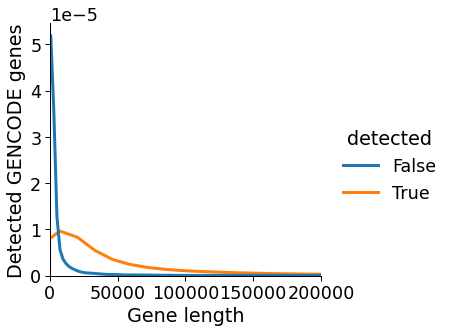

In [17]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='gene', 
                      subset='polya',
                      min_tpm=1,
                      xlim=200000,
                      opref='figures/')

In [18]:
# save this for narges
df.to_csv('det_polya_genes_len.tsv', sep='\t')

## GO on *protein coding* genes that are not detected at >= 1 TPM

In [19]:
print(len(df.index))
df = df.loc[df.biotype_category == 'protein_coding']
print(len(df.index))

49472
19969


In [20]:
dbs = ['GO_Biological_Process_2021',
       'GO_Cellular_Component_2021',
       'GO_Molecular_Function_2021',
       'KEGG_2021_Human']
bm = gp.parser.Biomart()
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
datasets.loc[datasets.Description.str.contains('Human')]

,Name,Description
156,hsapiens_gene_ensembl,Human genes (GRCh38.p13)


In [21]:
gids = df.loc[~df.detected, 'gid'].str.rsplit('.', n=1, expand=True)[0].to_frame()
gids = gids.squeeze().str.strip().tolist()
gids = bm.query(dataset='hsapiens_gene_ensembl',
           attributes=['ensembl_gene_id', 'external_gene_name'],
           filters={'ensembl_gene_id': gids})
gids = gids.loc[~gids.external_gene_name.isna()]
gnames = gids.external_gene_name.squeeze().str.strip().tolist()
go = gp.enrichr(gene_list=gnames,
                gene_sets=dbs,
                organism='Human',
                description='undet_genes',
                outdir='undet_genes_GO',
                cutoff=0.5)

## How many biosamples do we detect each detected gene in?

In [22]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 31968
Found 31 total samples


biosample,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,muscle,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels,n_samples
ENSG00000000003.14,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,29
ENSG00000000005.5,True,False,True,False,True,False,True,True,False,True,...,False,True,False,False,True,False,True,False,True,11
ENSG00000000419.12,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,31
ENSG00000000457.13,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,31
ENSG00000000460.16,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285981.1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
ENSG00000285982.1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,30
ENSG00000285988.1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
ENSG00000285990.1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,4


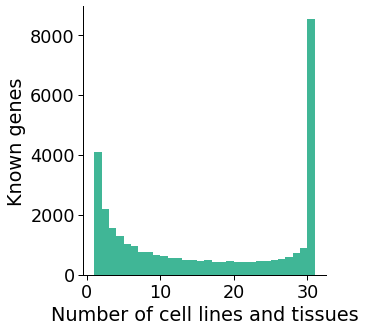

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
plot_biosamp_det(df,
                 how='gene',
                 min_tpm=1,
                 gene_subset='polya',
                 sample=None,
                 groupby='sample',
                 nov='Known',
                 opref='figures/human')